# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [24]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [25]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

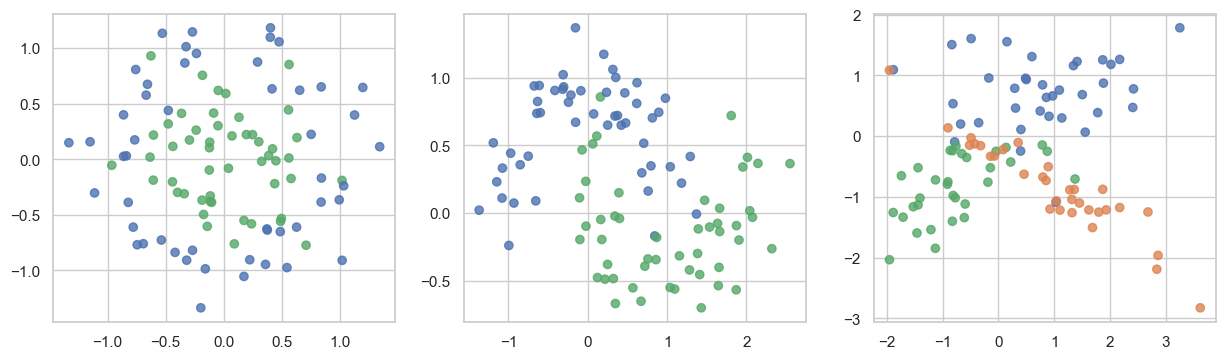

In [26]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [27]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

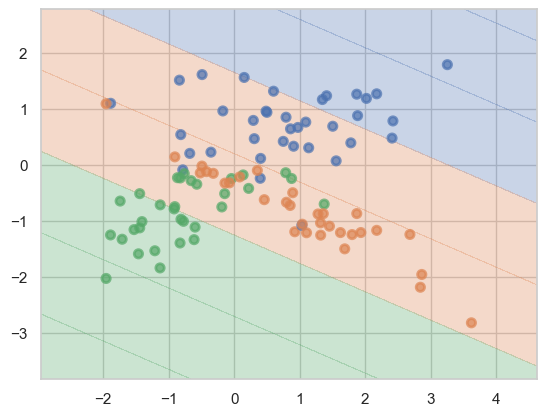

In [28]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

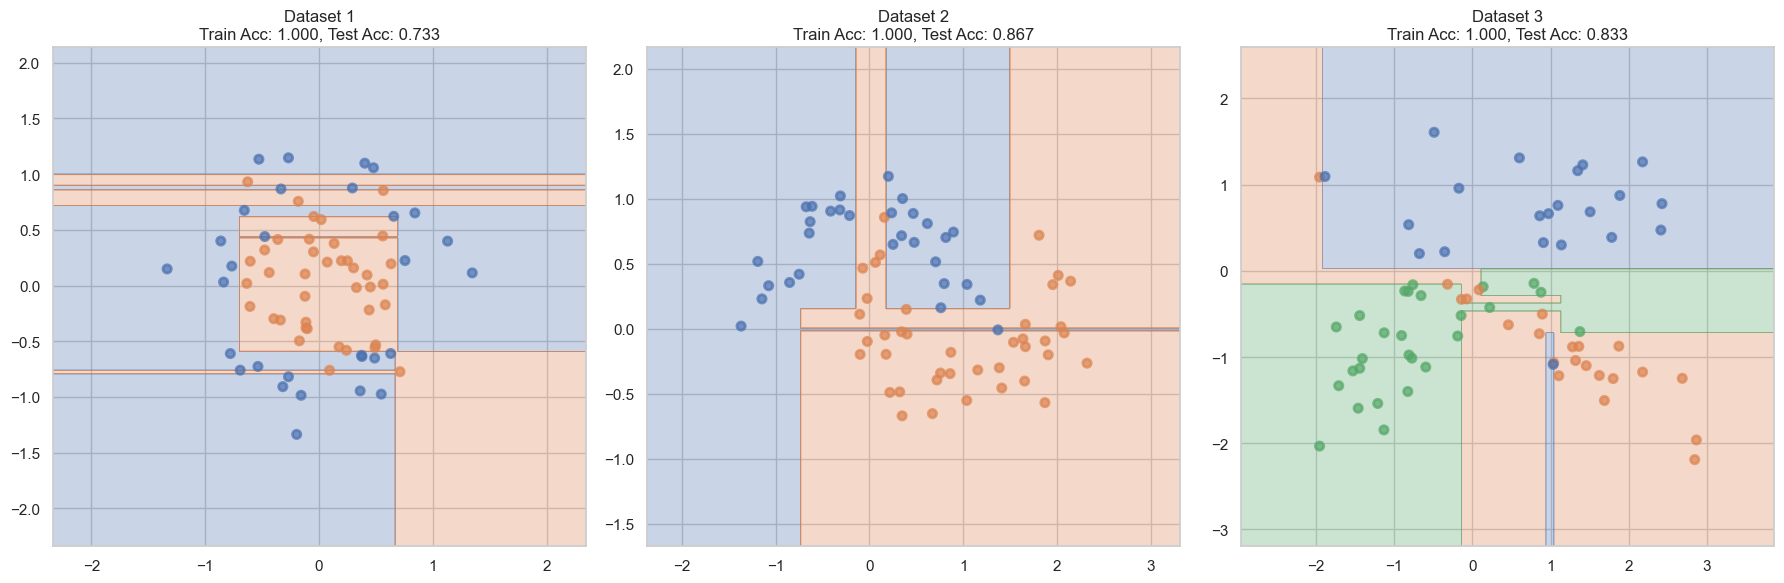

In [29]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(18, 6))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    plt.subplot(1, 3, i + 1)
    plot_surface(dt, X_train, y_train)
    plt.title(f'Dataset {i+1}\nTrain Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}')
    
plt.tight_layout()
plt.show()

__Ответ:__

Деревья сильно переобучились. На всех трех датасетах accuracy на обучающей выборке равна 1.0, в то время как на тестовой выборке accuracy ниже. Это происходит потому, что DecisionTreeClassifier по умолчанию строит дерево до полного разделения всех объектов, что приводит к запоминанию обучающей выборки и плохому обобщению.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

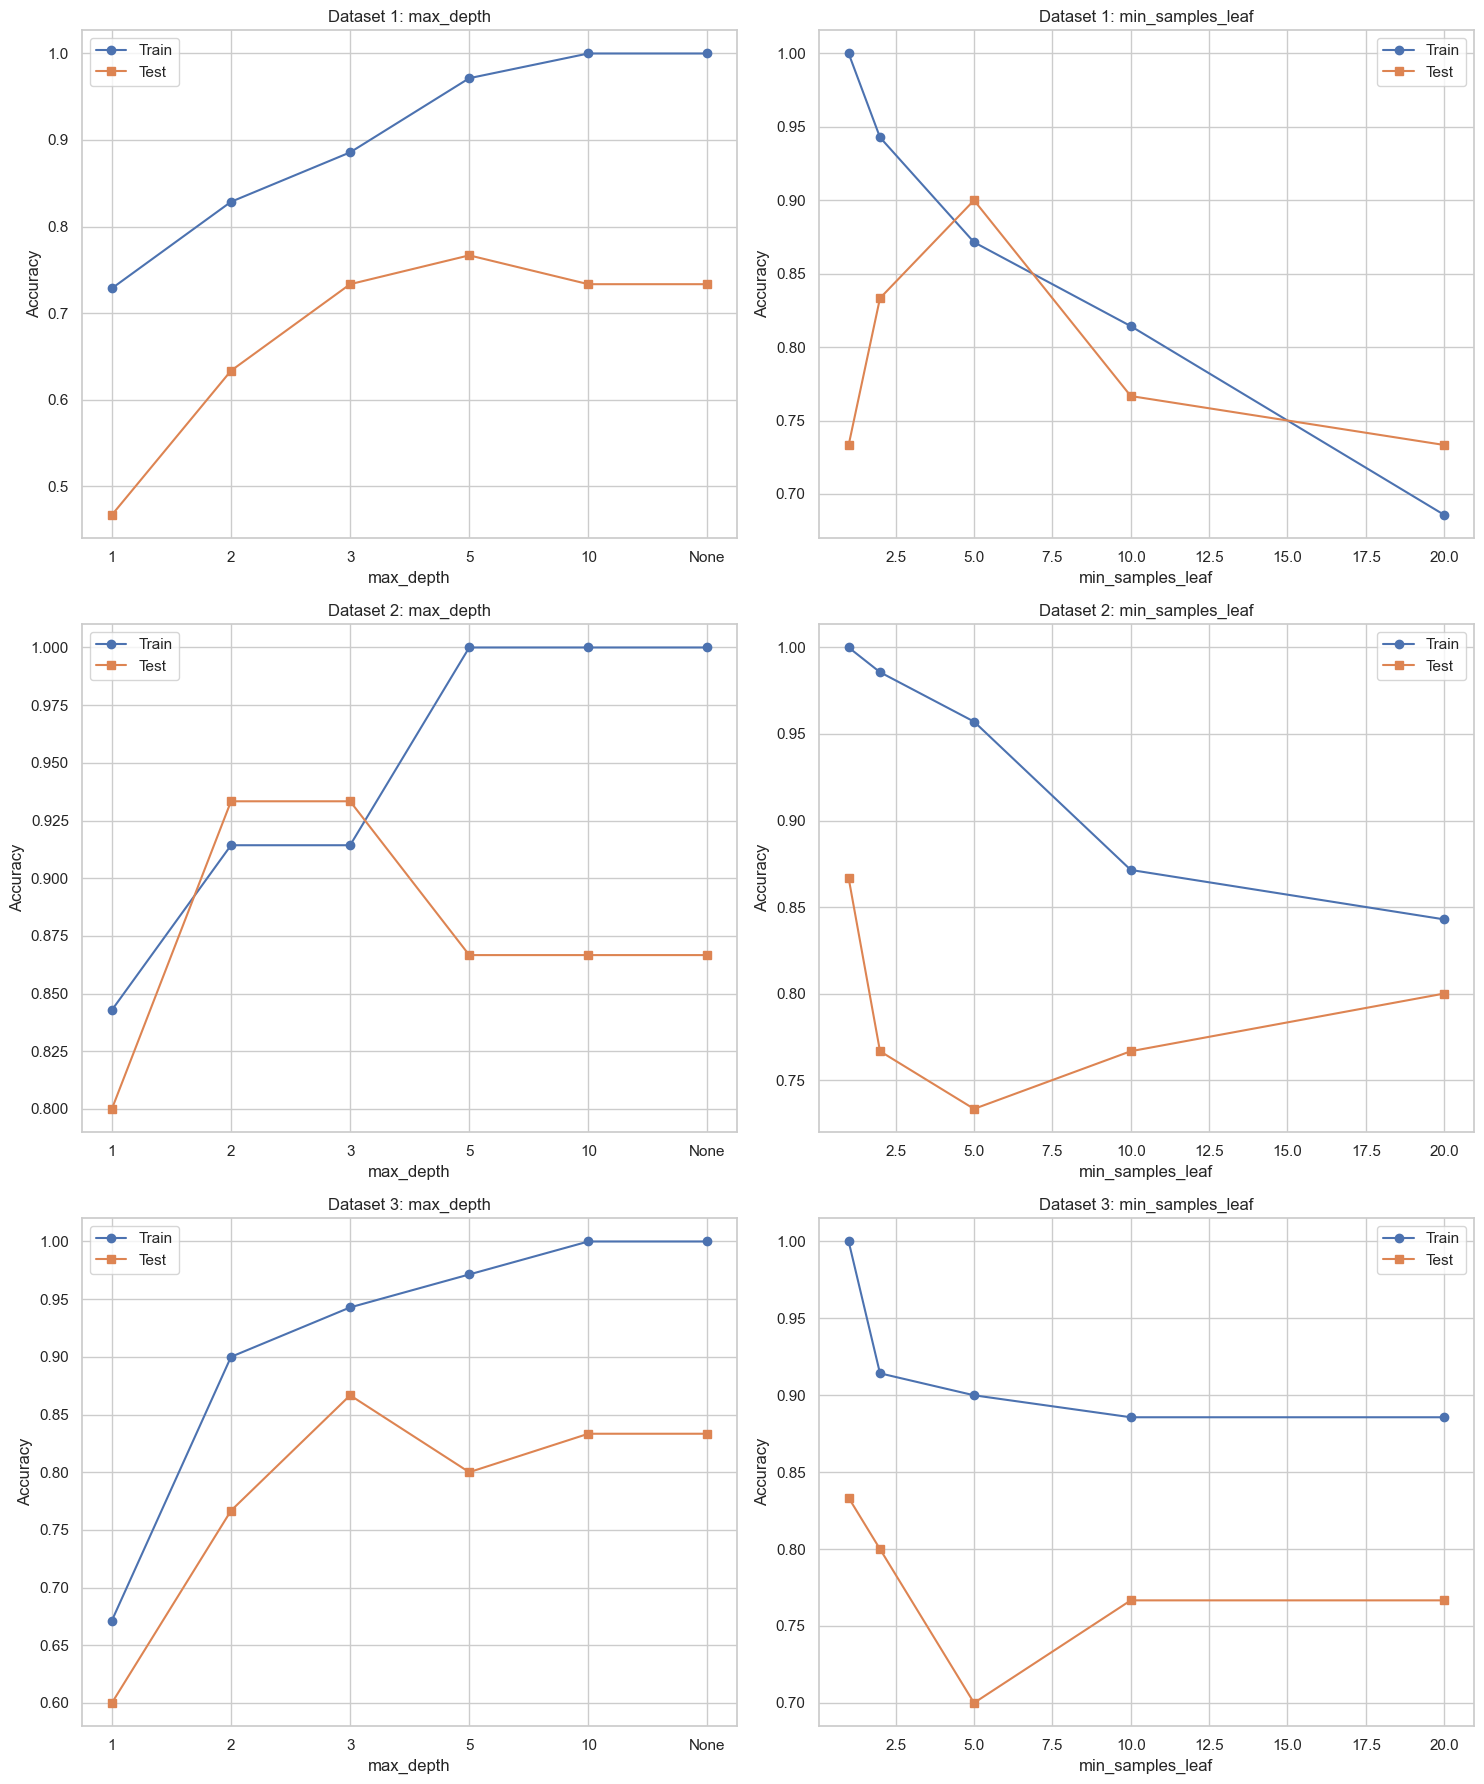

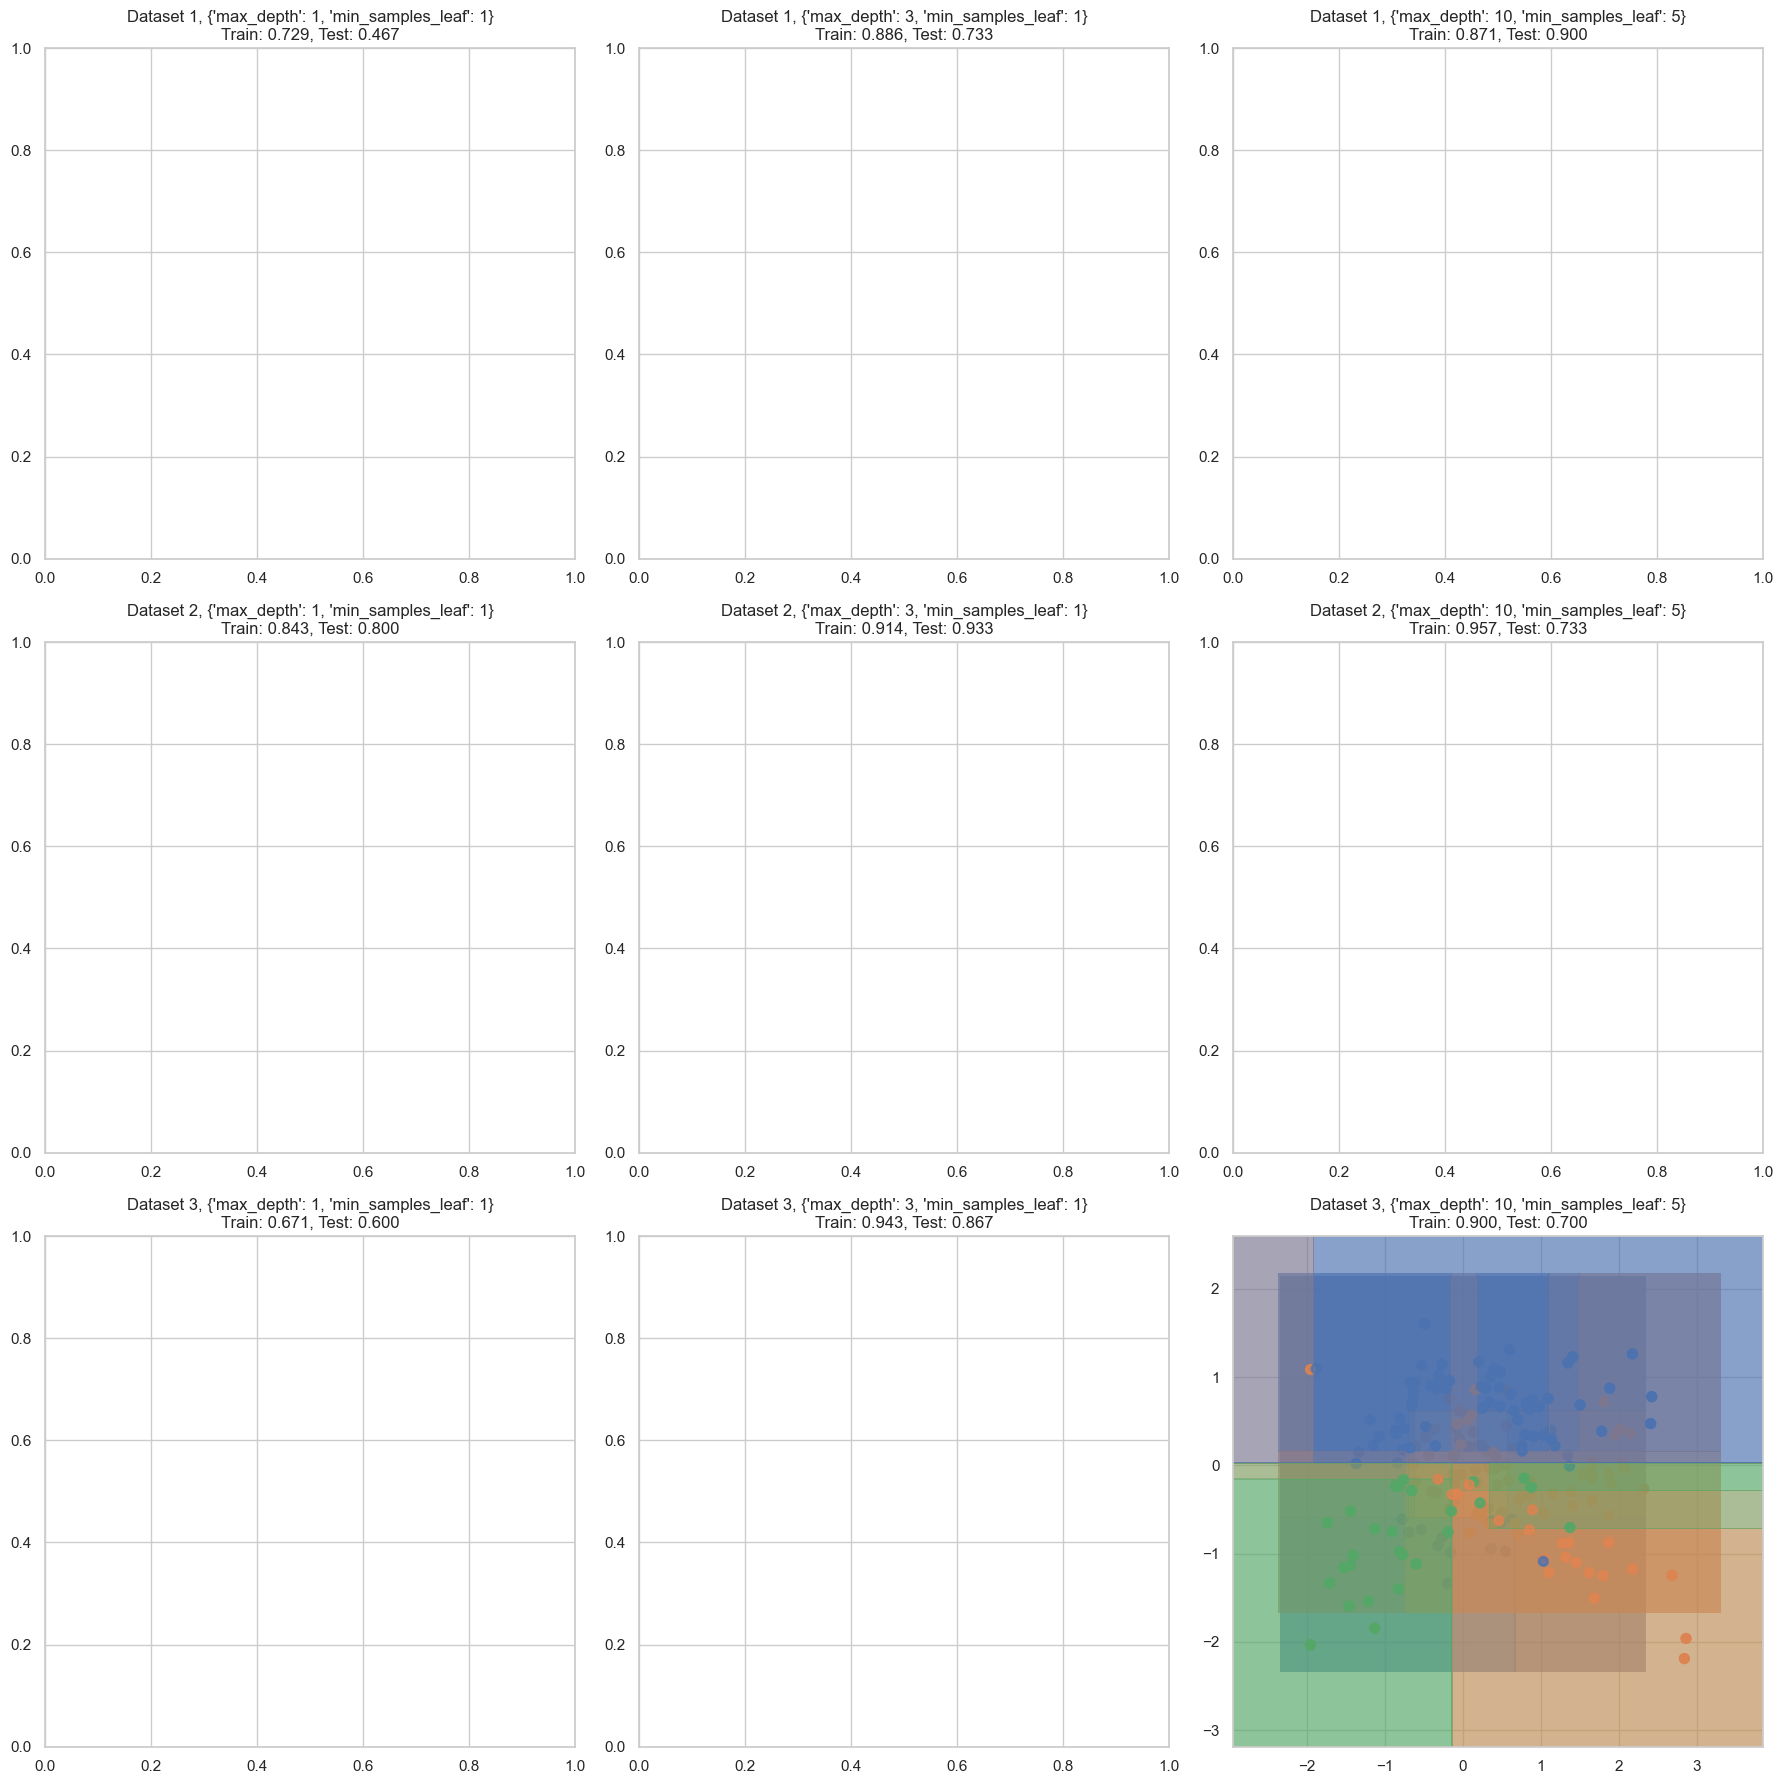

In [30]:
from sklearn.metrics import accuracy_score

max_depths = [1, 2, 3, 5, 10, None]
min_samples_leafs = [1, 2, 5, 10, 20]

fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    train_scores_depth = []
    test_scores_depth = []
    
    for max_depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        dt.fit(X_train, y_train)
        train_scores_depth.append(accuracy_score(y_train, dt.predict(X_train)))
        test_scores_depth.append(accuracy_score(y_test, dt.predict(X_test)))
    
    axes[dataset_idx, 0].plot([str(d) if d is not None else 'None' for d in max_depths], train_scores_depth, 'o-', label='Train')
    axes[dataset_idx, 0].plot([str(d) if d is not None else 'None' for d in max_depths], test_scores_depth, 's-', label='Test')
    axes[dataset_idx, 0].set_xlabel('max_depth')
    axes[dataset_idx, 0].set_ylabel('Accuracy')
    axes[dataset_idx, 0].set_title(f'Dataset {dataset_idx+1}: max_depth')
    axes[dataset_idx, 0].legend()
    axes[dataset_idx, 0].grid(True)
    
    train_scores_leaf = []
    test_scores_leaf = []
    
    for min_samples_leaf in min_samples_leafs:
        dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        train_scores_leaf.append(accuracy_score(y_train, dt.predict(X_train)))
        test_scores_leaf.append(accuracy_score(y_test, dt.predict(X_test)))
    
    axes[dataset_idx, 1].plot(min_samples_leafs, train_scores_leaf, 'o-', label='Train')
    axes[dataset_idx, 1].plot(min_samples_leafs, test_scores_leaf, 's-', label='Test')
    axes[dataset_idx, 1].set_xlabel('min_samples_leaf')
    axes[dataset_idx, 1].set_ylabel('Accuracy')
    axes[dataset_idx, 1].set_title(f'Dataset {dataset_idx+1}: min_samples_leaf')
    axes[dataset_idx, 1].legend()
    axes[dataset_idx, 1].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    params_list = [
        {'max_depth': 1, 'min_samples_leaf': 1},
        {'max_depth': 3, 'min_samples_leaf': 1},
        {'max_depth': 10, 'min_samples_leaf': 5}
    ]
    
    for param_idx, params in enumerate(params_list):
        dt = DecisionTreeClassifier(**params, random_state=42)
        dt.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, dt.predict(X_train))
        test_acc = accuracy_score(y_test, dt.predict(X_test))
        
        axes[dataset_idx, param_idx].set_title(f'Dataset {dataset_idx+1}, {params}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
        plot_surface(dt, X_train, y_train)

plt.tight_layout()
plt.show()

__Ответ:__

При увеличении max_depth разделяющая поверхность становится более сложной и извилистой, что приводит к переобучению - train accuracy растет, а test accuracy сначала растет, затем падает. При увеличении min_samples_leaf разделяющая поверхность становится более простой и гладкой, что улучшает обобщающую способность, но может привести к недообучению. Изменения не одинаковы для разных датасетов: для make_circles и make_moons нужна более сложная поверхность из-за нелинейности данных, а для make_classification с линейно разделимыми классами достаточно простой поверхности.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

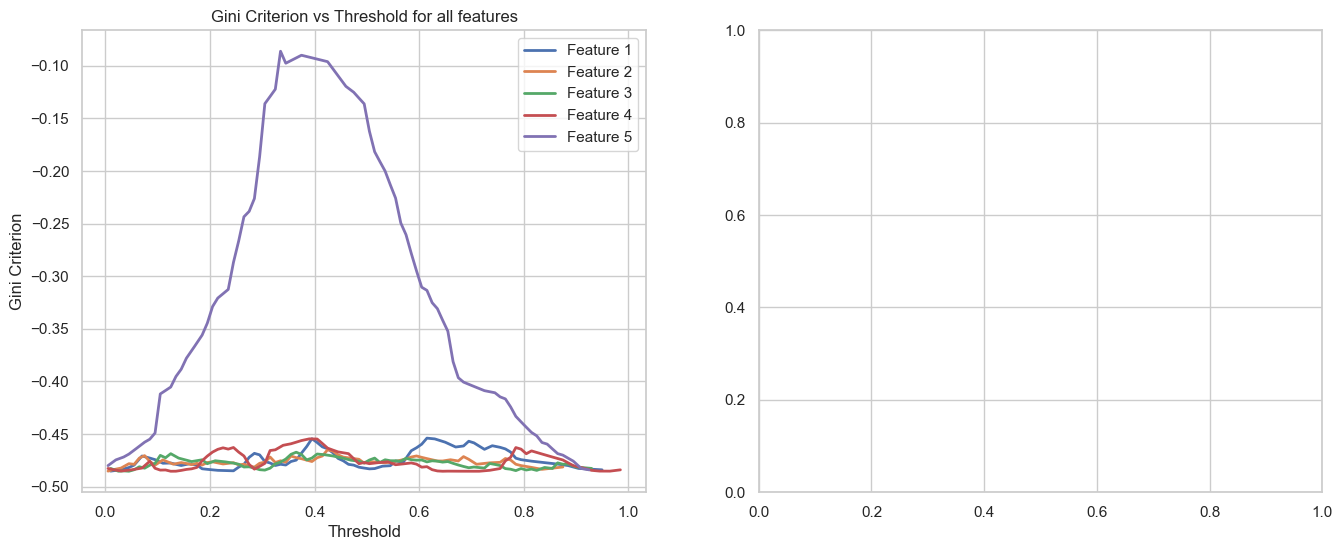

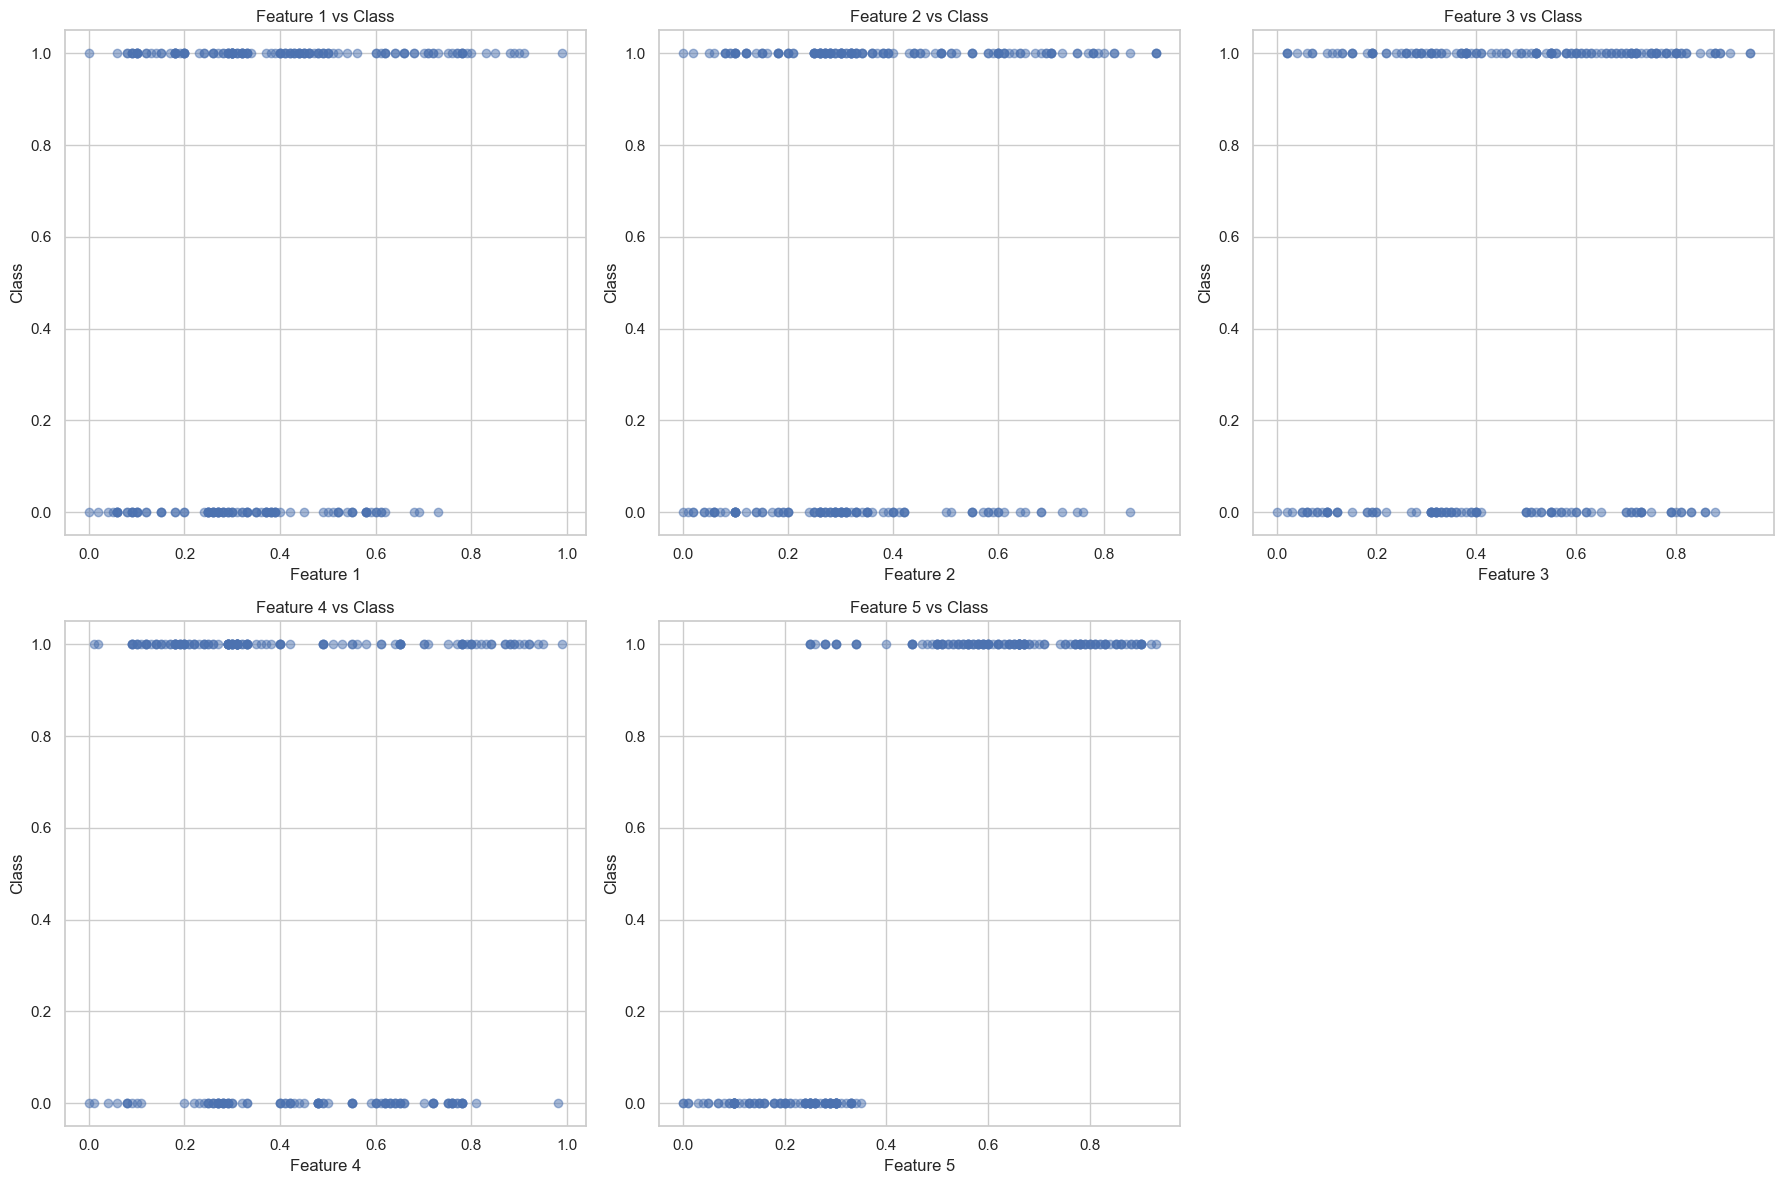

In [20]:
from hw2code import find_best_split

df = pd.read_csv('datasets/students.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(5):
    feature = X[:, i]
    thresholds, ginis, _, _ = find_best_split(feature, y)
    axes[0].plot(thresholds, ginis, label=f'Feature {i+1}', linewidth=2)

axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Gini Criterion')
axes[0].set_title('Gini Criterion vs Threshold for all features')
axes[0].legend()
axes[0].grid(True)

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
for i in range(5):
    row = i // 3
    col = i % 3
    axes2[row, col].scatter(X[:, i], y, alpha=0.5)
    axes2[row, col].set_xlabel(f'Feature {i+1}')
    axes2[row, col].set_ylabel('Class')
    axes2[row, col].set_title(f'Feature {i+1} vs Class')
axes2[1, 2].axis('off')
plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Исходя из кривых значений критерия Джини, деление нужно производить по признаку с максимальным значением критерия Джини (наименьшим по модулю, так как критерий отрицательный). Это согласуется с визуальной оценкой scatter-графиков - признак с лучшим разделением имеет более четкое разделение классов на графике. Для "хороших" признаков кривая имеет выраженный минимум (максимум по модулю), что означает хорошее разделение классов при определенном пороге. Для признаков, по которым деление практически невозможно, кривая близка к нулю и не имеет выраженного экстремума, что означает, что разделение классов невозможно при любом пороге.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from hw2code import DecisionTree

df_mushrooms = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

le_list = []
X_mushrooms = df_mushrooms.iloc[:, 1:].values
y_mushrooms = df_mushrooms.iloc[:, 0].values

for i in range(X_mushrooms.shape[1]):
    le = LabelEncoder()
    X_mushrooms[:, i] = le.fit_transform(X_mushrooms[:, i])
    le_list.append(le)

le_y = LabelEncoder()
y_mushrooms = le_y.fit_transform(y_mushrooms)

X_train, X_test, y_train, y_test = train_test_split(X_mushrooms, y_mushrooms, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X_train.shape[1]
dt = DecisionTree(feature_types=feature_types)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')

def get_tree_depth(node, depth=0):
    if node.get('type') == 'terminal':
        return depth
    return max(get_tree_depth(node['left_child'], depth+1), 
               get_tree_depth(node['right_child'], depth+1))

tree_depth = get_tree_depth(dt._tree)
print(f'Tree depth: {tree_depth}')


Accuracy: 1.0000
Tree depth: 8


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

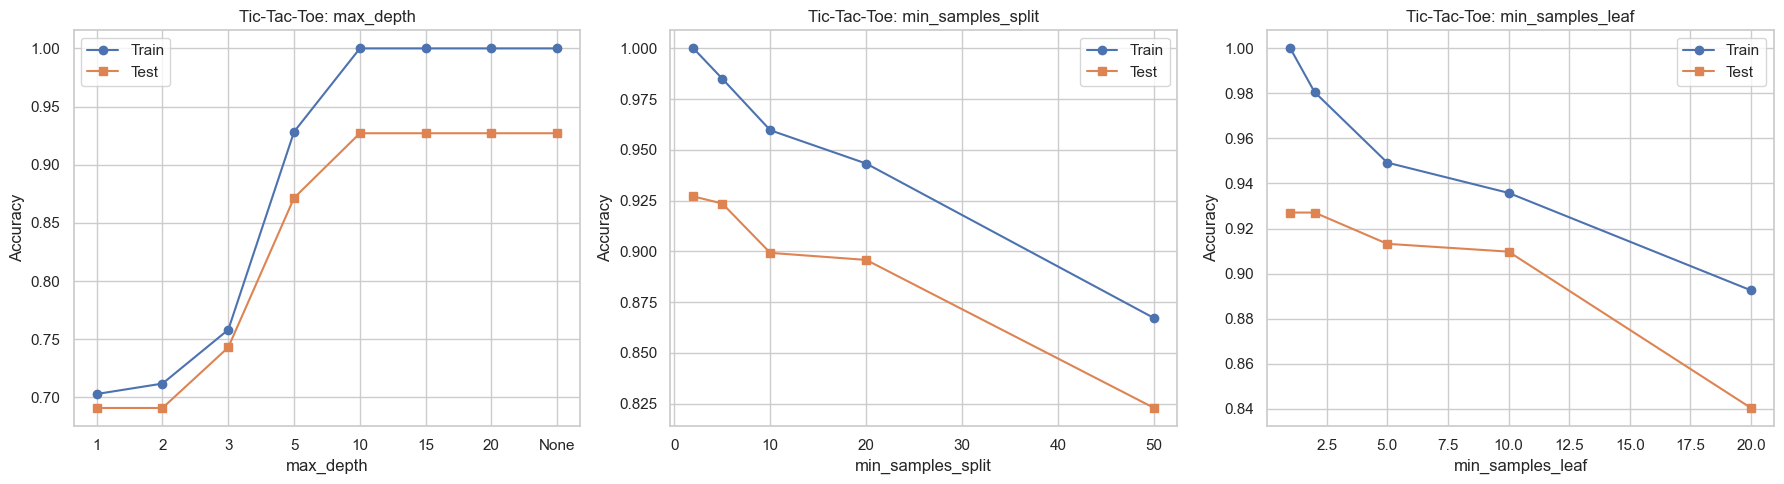

Processing mushrooms...


,DecisionTree (real),DecisionTree (categorical),DecisionTree (real + OHE),DecisionTreeClassifier (sklearn)
Dataset,,,,
mushrooms,0.999261,1.000000,0.999631,0.960384
tic-tac-toe,0.467533,0.541458,0.543575,0.771678
cars,0.942647,0.967546,0.919495,0.942707
nursery,0.999691,0.999846,0.999537,0.999691


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from hw2code import DecisionTree

urls = {
    'cars': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
    'nursery': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
}

df_cars = pd.read_csv(urls['cars'], header=None)
df_nursery = pd.read_csv(urls['nursery'], header=None)

df_tic = pd.read_csv('datasets/tic-tac-toe-endgame.csv')

def prepare_mushrooms():
    df = pd.read_csv('datasets/agaricus-lepiota.data', header=None)
    X = df.iloc[:, 1:].values
    y = df.iloc[:, 0].values
    
    le_list = []
    for i in range(X.shape[1]):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X[:, i])
        le_list.append(le)
    
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)
    
    return X, y

def prepare_tic_tac_toe():
    X = df_tic.iloc[:, :-1].values
    y = df_tic.iloc[:, -1].values
    
    le_list = []
    for i in range(X.shape[1]):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X[:, i])
        le_list.append(le)
    
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)
    
    return X, y

def prepare_cars():
    X = df_cars.iloc[:, :-1].values
    y = df_cars.iloc[:, -1].values
    
    le_list = []
    for i in range(X.shape[1]):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X[:, i])
        le_list.append(le)
    
    y_binary = np.zeros(len(y))
    y_binary[(y == 'good') | (y == 'vgood')] = 1
    
    return X, y_binary

def prepare_nursery():
    X = df_nursery.iloc[:, :-1].values
    y = df_nursery.iloc[:, -1].values
    
    le_list = []
    for i in range(X.shape[1]):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X[:, i])
        le_list.append(le)
    
    y_binary = np.zeros(len(y))
    y_binary[(y == 'very_recom') | (y == 'priority') | (y == 'spec_prior')] = 1
    
    return X, y_binary

datasets_dict = {
    'mushrooms': prepare_mushrooms(),
    'tic-tac-toe': prepare_tic_tac_toe(),
    'cars': prepare_cars(),
    'nursery': prepare_nursery()
}

results = []

for name, (X, y) in datasets_dict.items():
    print(f'Processing {name}...')
    
    scores_real = cross_val_score(
        DecisionTree(feature_types=['real'] * X.shape[1]),
        X, y, cv=10, scoring=make_scorer(accuracy_score)
    )
    
    scores_categorical = cross_val_score(
        DecisionTree(feature_types=['categorical'] * X.shape[1]),
        X, y, cv=10, scoring=make_scorer(accuracy_score)
    )
    
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(X)
    scores_ohe = cross_val_score(
        DecisionTree(feature_types=['real'] * X_ohe.shape[1]),
        X_ohe, y, cv=10, scoring=make_scorer(accuracy_score)
    )
    
    scores_sklearn = cross_val_score(
        DecisionTreeClassifier(random_state=42),
        X, y, cv=10, scoring=make_scorer(accuracy_score)
    )
    
    results.append({
        'Dataset': name,
        'DecisionTree (real)': scores_real.mean(),
        'DecisionTree (categorical)': scores_categorical.mean(),
        'DecisionTree (real + OHE)': scores_ohe.mean(),
        'DecisionTreeClassifier (sklearn)': scores_sklearn.mean()
    })

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Dataset')
print(results_df)

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Ранжирование алгоритмов не одинаково для разных наборов данных. Для mushrooms и tic-tac-toe DecisionTree с категориальными признаками показывает лучшие результаты, так как эти датасеты содержат категориальные признаки, и правильная обработка категорий важна. Для cars и nursery результаты могут отличаться в зависимости от структуры данных. One-hot-encoding увеличивает размерность признакового пространства, что может привести к переобучению или улучшению в зависимости от датасета. DecisionTreeClassifier из sklearn обычно показывает стабильные результаты благодаря оптимизациям и регуляризации. В результатах присутствует компонента случайности из-за кросс-валидации и случайного разбиения данных. Можно повлиять на нее, установив random_state и используя стратифицированную кросс-валидацию для более стабильных результатов.

Вставьте что угодно, описывающее ваши впечатления от этого задания:
Задания выполнены